# Merging of classification results

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import evaluate
import boosting
import merge
import load

In [2]:
# Load evaluation data
test_columns = ['returnQuantity', 'articleID', 'productGroup', 'customerID', 'voucherID']
test_predictions = merge.merged_predictions(test=True, keep_columns=test_columns)
test_train = evaluate.test_complement(test_predictions)

# Load classification data
class_columns = ['articleID', 'productGroup', 'customerID', 'voucherID']
class_predictions = merge.merged_predictions(keep_columns=class_columns)
class_train = load.orders_train()

## Confidences
Approximately 4% of predictions by team C have unknown confidences, making imputation necessary before merge approaches based on confidence can be applied. Because of this relatively small number, we can without loss impute missing values using the mean confidence of Team C. The mean showed stable behavior across all splits in the test and prediction data.

In [3]:
# Impute confidences
test_imputed = merge.impute_confidence(test_predictions)
class_imputed = merge.impute_confidence(class_predictions)

To be able to use the confidenes as multipliers they are expressed as ratios to the classifiers mean. The resulting distribution of the imputed confidences is depicted in the figure below.

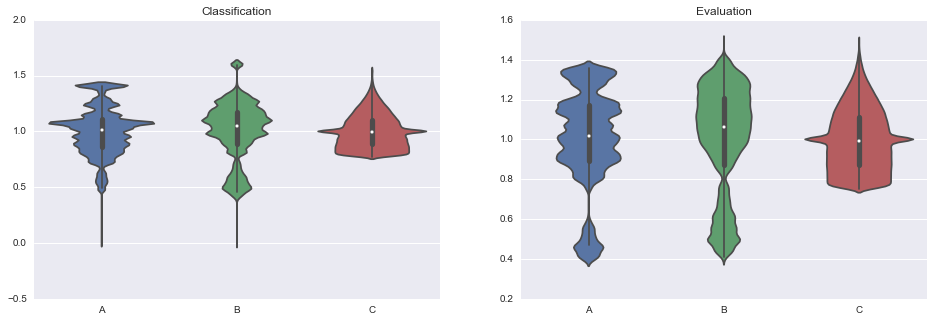

In [4]:
# Violinplot  
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.set_title('Classification')
ax = sns.violinplot(data=class_imputed['confidence'], ax=ax1)
ax2.set_title('Evaluation')
ax = sns.violinplot(data=test_imputed['confidence'], ax=ax2)

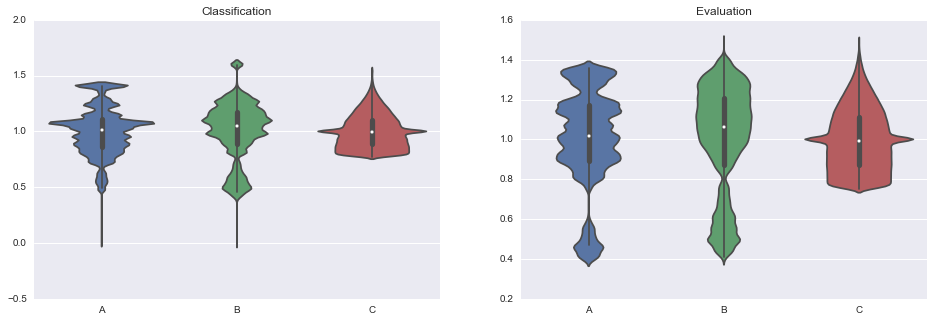

In [5]:
# Violinplot  
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.set_title('Classification')
ax = sns.violinplot(data=class_imputed['confidence'], ax=ax1)
ax2.set_title('Evaluation')
ax = sns.violinplot(data=test_imputed['confidence'], ax=ax2)

## Merge approach 1: Naive Majority Vote
This approach takes for each row the most common prediction. As we have 3 teams, there is always a majority. The naive majority vote relies on no assumptions about performance and confidence.

In [6]:
test_naive = merge.naive_majority_vote(test_predictions)
class_naive = merge.naive_majority_vote(class_predictions)

Evaluating this approach shows a very slight improvement compared to the best single team classification (cf. figure below).

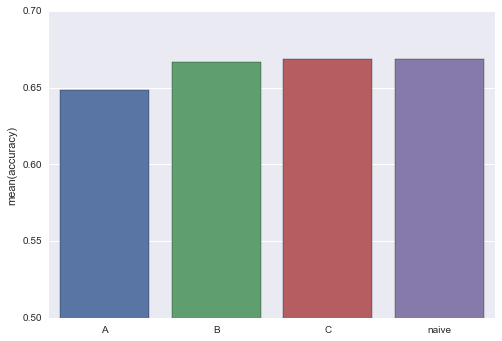

In [7]:
# Calculate mean accuracies
naive_accuracies = evaluate.mean_accuracies(test_naive)

# Barplot
ax = sns.barplot(x=naive_accuracies.index, y=naive_accuracies['accuracy'])
lim = ax.set_ylim([0.5, 0.7])

(The values are 64.85%, 66.66%, 66.86% and **66.89%** in that order.)

Despite the small improvement, the new classification seems to resolve a lot of arguments between the teams (cf. figure below). The naive merge seems to agree with teams A and C (under 1% distinct rows), while still disagreeing mostly with team B (11%).

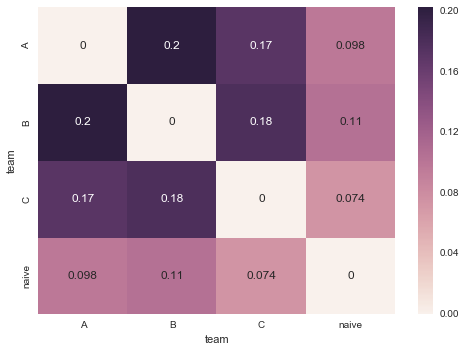

In [8]:
# Calculate difference for each combination
naive_differences = evaluate.distinct_predictions(class_naive)

# Heatmap
ax = sns.heatmap(naive_differences, annot=True)

The differences between the naive merge and team B seem similar to the differences team B had with other teams. The most of them being in the top four splits that were not present in the test set, cf. figure below.

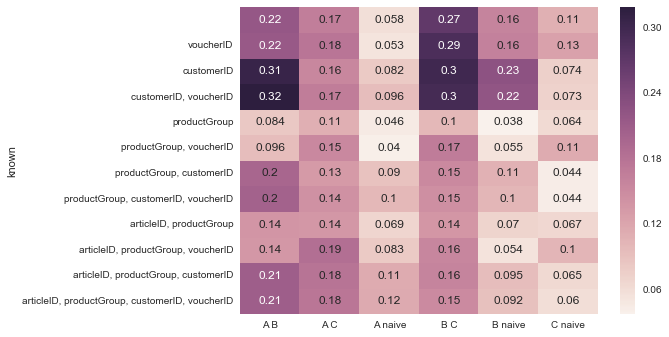

In [9]:
# Calculate differences across splits
naive_split_differences = evaluate.distinct_split_predictions(class_train, class_naive)

# Heatmap
ax = sns.heatmap(naive_split_differences, annot=True)

## Approach 2: Weighted Majority Vote
As improvement to the naive version confidences and accuracies can be combined to weights. We evaluated different ways of doing so: ignoring confidences, ignoring accuracies, handpicked accuracy values and optimized accuracy and confidence ratios. We evaluated on the test set and mostly saw slight improvements to the naive variant. The following weights turned out to yield the best results:

$$
weight_{c,i} = \bigg(\dfrac{confidence_{c,i}}{confidence_{c,\varnothing}}\bigg)^{2} \cdot \bigg(\dfrac{accuracy_c}{accuracy_\varnothing}\bigg)^{61}
$$

The confidence ratio yielded best results being squared. The high exponent of the accuracy ratio is due to the small differences among the classifiers. The values returned by this exponentiation are as below.

In [26]:
pd.DataFrame(np.power(mean_accuracies / mean_accuracies.mean(), 61))

,accuracy
A,0.305747
B,1.635136
C,1.966170


The strong boost of B and C to the disadvantage of A led to the best results. We were not able to produce better performance with other weights.

In [45]:
# Evaluate mean accuracies for each classifier
mean_accuracies = evaluate.mean_accuracies(test_predictions)['accuracy']

# Adjust range of accuracy ratios
accuracy_weights = np.power(mean_accuracies / mean_accuracies.mean(), 61)

# Adjust range of confidence ratios
test_applied_confidences = test_imputed.copy()
test_applied_confidences['confidence'] = test_applied_confidences['confidence'].applymap(lambda d: np.power(d, 2))

class_applied_confidences = class_imputed.copy()
class_applied_confidences['confidence'] = class_applied_confidences['confidence'].applymap(lambda d: np.power(d, 2))

# Calculate majority vote for test and classification data
test_weighted = merge.weighted_majority_vote(test_applied_confidences, accuracy_weights)
class_weighted = merge.weighted_majority_vote(class_applied_confidences, accuracy_weights)

The weighted majority performs better than the naive approach (**67.10%** and **66.88%**).

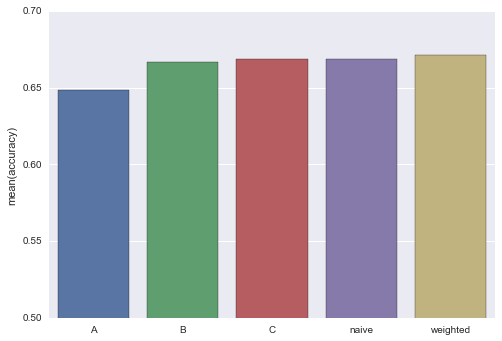

In [34]:
merged = test_naive.copy()
merged['prediction', 'weighted'] = test_weighted['prediction']['weighted']

# Calculate mean accuracies
mean_accuracies = evaluate.mean_accuracies(merged)

# Barplot
ax = sns.barplot(x=mean_accuracies.index, y=mean_accuracies['accuracy'])
lim = ax.set_ylim([0.5, 0.7])

However, the differences turn out to be greater. As a result of the strong accuracy weighting, the difference with A is the great.

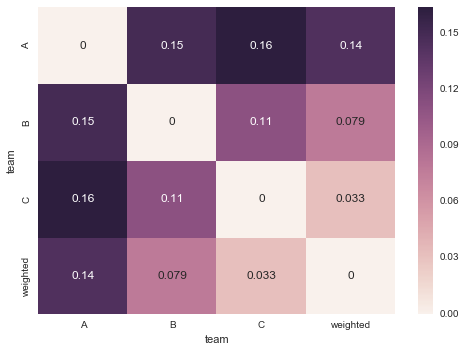

In [31]:
# Calculate difference for each combination
weighted_differences = evaluate.distinct_predictions(class_weighted_confidence)

# Heatmap
ax = sns.heatmap(weighted_differences, annot=True)

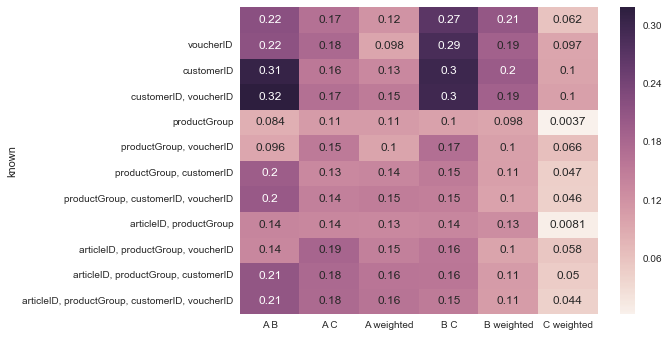

In [47]:
# Calculate differences across splits
weighted_split_differences = evaluate.distinct_split_predictions(class_train, class_weighted)

# Heatmap
ax = sns.heatmap(weighted_split_differences, annot=True)

## Approach 3: Machine Leaning Problem

In [49]:
class_boosted = boosting.boosted_class_data()

In [60]:
merged_boosted = class_weighted.copy()
merged_boosted['prediction', 'boosted'] = class_boosted['merged_prediction'].astype(bool)
merged_boosted = merged_boosted.drop(('prediction', 'weighted'), axis=1)

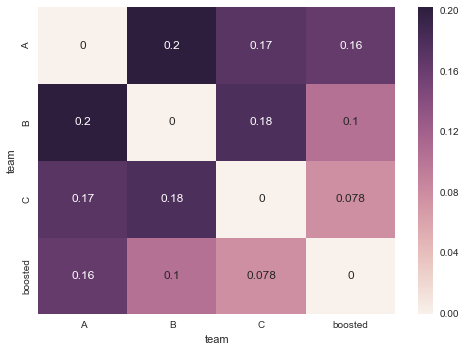

In [61]:
# Calculate difference for each combination
boosted_differences = evaluate.distinct_predictions(merged_boosted)

# Heatmap
ax = sns.heatmap(boosted_differences, annot=True)

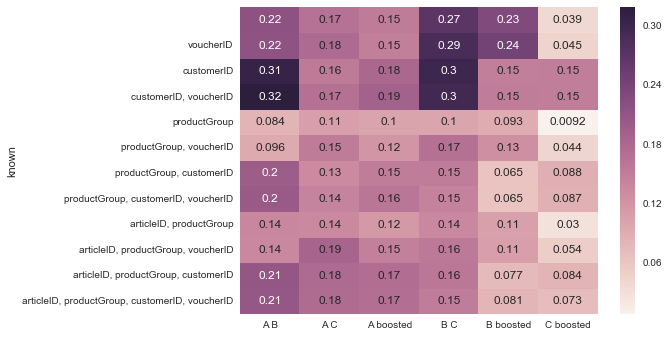

In [63]:
# Calculate differences across splits
boosted_split_differences = evaluate.distinct_split_predictions(class_train, merged_boosted)

# Heatmap
ax = sns.heatmap(boosted_split_differences, annot=True)